In [36]:
from nilearn import datasets
from nilearn import plotting
from nilearn.image import load_img, new_img_like, concat_imgs, resample_to_img
from nilearn.input_data import NiftiLabelsMasker
import os
import glob
import numpy as np
from random import sample
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats.stats import pearsonr
import random
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
#To ensure reproducibility
random.seed(39)
np.random.seed(39)

In [4]:
dataset_path = "/Users/hasnainmamdani/Academics/McGill/thesis/sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
scans = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
scans.sort()
print('Number of subjects: %d' % len(scans))

Number of subjects: 1401


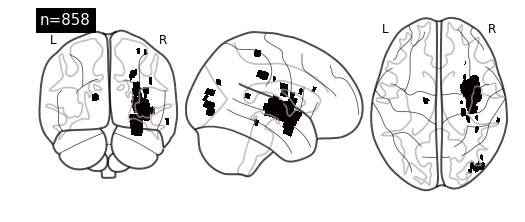

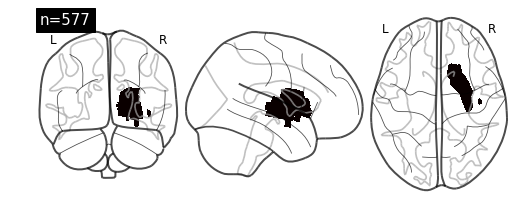

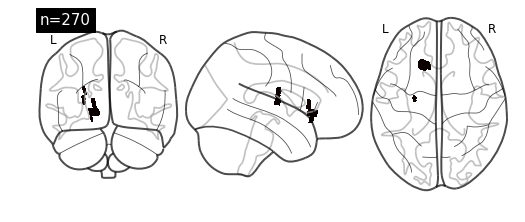

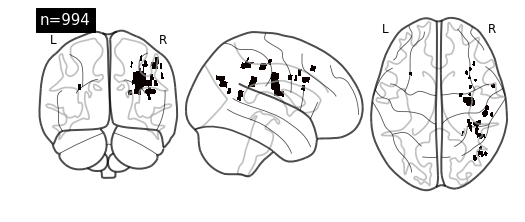

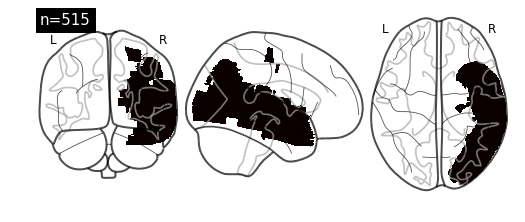

In [5]:
# visualize some samples of the dataset
for i in sample(range(len(scans)), 5):
    plotting.plot_glass_brain(scans[i], title='n='+str(i))  

In [6]:
# load an atlas with brain anatomy labelled
atlas_cort = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-1mm', symmetric_split=True)
atlas_subcort = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-1mm')

atlas_cort_img = atlas_cort.maps
atlas_subcort_filename = atlas_subcort.maps

labels_cort = atlas_cort.labels
labels_subcort = atlas_subcort.labels

In [7]:
print(len(labels_cort))
print(len(labels_subcort))

97
22


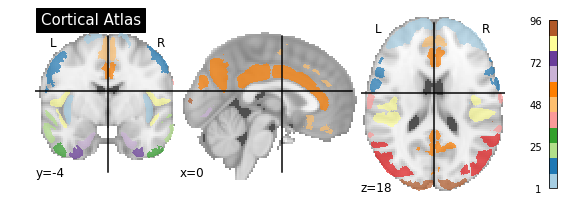

In [8]:
# visualize loaded atlas labels 
plotting.plot_roi(atlas_cort_img, colorbar=True, cmap="Paired", title="Cortical Atlas")

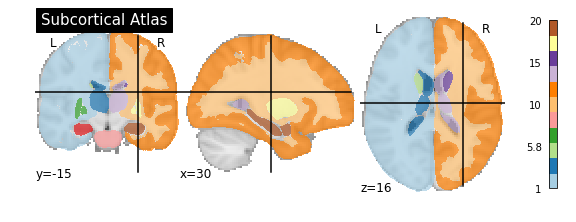

In [315]:
plotting.plot_roi(atlas_subcort_filename, colorbar=True, cmap="Paired", title="Subcortical Atlas")

In [91]:
atlas_cort_data = atlas_cort_img.get_fdata()
atlas_subcort_img = load_img(atlas_subcort_filename)
atlas_subcort_data = atlas_subcort_img.get_fdata()

atlas_data_shape = atlas_cort_data.shape
print(atlas_cort_data.shape)
print(atlas_subcort_data.shape)

(182, 218, 182)
(182, 218, 182)


In [92]:
np.unique(atlas_cort_data)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
       54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.,
       67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79.,
       80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 92.,
       94., 95., 96.])

In [93]:
labels_cort

['Background',
 'Left Frontal Pole',
 'Right Frontal Pole',
 'Left Insular Cortex',
 'Right Insular Cortex',
 'Left Superior Frontal Gyrus',
 'Right Superior Frontal Gyrus',
 'Left Middle Frontal Gyrus',
 'Right Middle Frontal Gyrus',
 'Left Inferior Frontal Gyrus, pars triangularis',
 'Right Inferior Frontal Gyrus, pars triangularis',
 'Left Inferior Frontal Gyrus, pars opercularis',
 'Right Inferior Frontal Gyrus, pars opercularis',
 'Left Precentral Gyrus',
 'Right Precentral Gyrus',
 'Left Temporal Pole',
 'Right Temporal Pole',
 'Left Superior Temporal Gyrus, anterior division',
 'Right Superior Temporal Gyrus, anterior division',
 'Left Superior Temporal Gyrus, posterior division',
 'Right Superior Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, anterior division',
 'Right Middle Temporal Gyrus, anterior division',
 'Left Middle Temporal Gyrus, posterior division',
 'Right Middle Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, temporooccipita

In [94]:
# this method checks for every label in the list of labels and find and remove
# labels that are not prsent in the data
def find_and_delete_unused_labels(data, labels_list):
    print("Filtering labels")
    unused_labels = []
    for i in range(len(labels_list)):
        if(not i in data):
            unused_labels.append(i)
            print(i, labels_list[i])
    
    shape = data.shape
    data = data.ravel()
    for i in sorted(unused_labels, reverse=True):
        data = [x-1 if x > i else x for x in data]
        del labels_list[i]
        
    data = np.array(data).reshape(shape)
    
    return data, labels_list

In [95]:
# cortical atlas has certain unused labels, let's clean them
atlas_cort_data, labels_cort = find_and_delete_unused_labels(atlas_cort_data, labels_cort)

Filtering labels
19 Left Superior Temporal Gyrus, posterior division
20 Right Superior Temporal Gyrus, posterior division
93 Left Supracalcarine Cortex


In [97]:
np.unique(atlas_cort_data)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93.])

In [98]:
# function to check overlap among atlases
# inputs are 1-D
def check_overlap(a, b, label_names=False, labels_a=None, labels_b=None):
    assert a.shape == b.shape
    print("total voxels:", a.shape[0])
    res = {}
    for i in range(len(a)):
        if a[i] != 0 and b[i] != 0:
            
            if(label_names):           
                if (labels_a[a[i]], labels_b[b[i]]) not in res.keys():
                    res[(labels_a[a[i]], labels_b[b[i]])] = 1
                else:
                    res[(labels_a[a[i]], labels_b[b[i]])] += 1
            else:           
                if (a[i], b[i]) not in res.keys():
                    res[(a[i], b[i])] = 1
                else:
                    res[(a[i], b[i])] += 1               
    return res

In [99]:
overlap = check_overlap(atlas_cort_data.ravel().astype(int), atlas_subcort_data.ravel().astype(int)\
                        , True, labels_cort, labels_subcort)
print("('Cortical region', 'Subcortical region'): # of overlapping voxels")
overlap

total voxels: 7221032
('Cortical region', 'Subcortical region'): # of overlapping voxels


{('Right Middle Temporal Gyrus, posterior division',
  'Right Cerebral Cortex '): 4334,
 ('Right Middle Temporal Gyrus, temporooccipital part',
  'Right Cerebral Cortex '): 3828,
 ('Right Postcentral Gyrus', 'Right Cerebral Cortex '): 8140,
 ('Right Supramarginal Gyrus, posterior division',
  'Right Cerebral Cortex '): 2559,
 ('Right Supramarginal Gyrus, anterior division',
  'Right Cerebral Cortex '): 2259,
 ('Right Angular Gyrus', 'Right Cerebral Cortex '): 4811,
 ('Right Inferior Temporal Gyrus, temporooccipital part',
  'Right Cerebral Cortex '): 2889,
 ('Right Inferior Temporal Gyrus, posterior division',
  'Right Cerebral Cortex '): 1871,
 ('Right Planum Temporale', 'Right Cerebral Cortex '): 731,
 ('Right Middle Temporal Gyrus, anterior division',
  'Right Cerebral Cortex '): 856,
 ('Right Precentral Gyrus', 'Right Cerebral Cortex '): 9837,
 ('Right Central Opercular Cortex', 'Right Cerebral Cortex '): 3753,
 ('Right Superior Temporal Gyrus, anterior division',
  'Right Cerebral

In [100]:
# overlapping regions in subcort
np.unique(np.array([x[1] for x in overlap.keys()]))

array(['Left Cerebral Cortex ', 'Left Cerebral White Matter',
       'Right Cerebral Cortex ', 'Right Cerebral White Matter'],
      dtype='<U27')

In [101]:
# now we filter the 4 overlaping regions in subcort atlas obtained above
print(np.unique(atlas_subcort_data))

atlas_subcort_data[(atlas_subcort_data==1) | (atlas_subcort_data==2) | \
                   (atlas_subcort_data==12) | (atlas_subcort_data==13)] = 0

print(np.unique(atlas_subcort_data))
atlas_subcort_data, labels_subcort = find_and_delete_unused_labels(atlas_subcort_data, labels_subcort)
print(len(labels_subcort))
print(np.unique(atlas_subcort_data))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]
[ 0.  3.  4.  5.  6.  7.  8.  9. 10. 11. 14. 15. 16. 17. 18. 19. 20. 21.]
Filtering labels
1 Left Cerebral White Matter
2 Left Cerebral Cortex 
12 Right Cerebral White Matter
13 Right Cerebral Cortex 
18
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]


In [102]:
labels_subcort

['Background',
 'Left Lateral Ventrical',
 'Left Thalamus',
 'Left Caudate',
 'Left Putamen',
 'Left Pallidum',
 'Brain-Stem',
 'Left Hippocampus',
 'Left Amygdala',
 'Left Accumbens',
 'Right Lateral Ventricle',
 'Right Thalamus',
 'Right Caudate',
 'Right Putamen',
 'Right Pallidum',
 'Right Hippocampus',
 'Right Amygdala',
 'Right Accumbens']

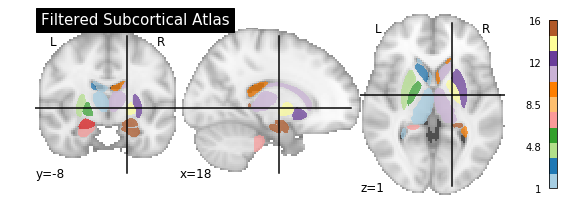

In [103]:
#visualize filtered subcortical atlas
plotting.plot_roi(new_img_like(atlas_subcort_img, atlas_subcort_data), colorbar=True, cmap="Paired", \
                  title='Filtered Subcortical Atlas')

[ 0.  1. 10.]


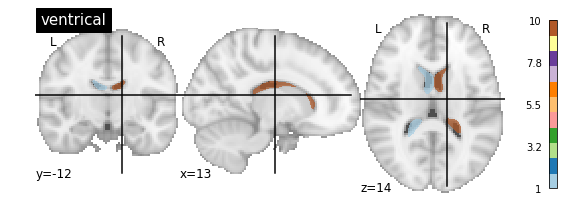

In [107]:
# visulizing ventricals for example
aa = np.copy(atlas_subcort_data)
aa[(aa!=1) & (aa!=10)] = 0
print(np.unique(aa))
plotting.plot_roi(new_img_like(atlas_subcort_img, aa), colorbar=True, cmap="Paired", title='ventrical')

In [22]:
# this method updates the labels (in the data) of the atlas such that their initial label is the \
# next integer after the last label t of the other atlas and the labels increase sequentially
def adjust_labels(x, t):
    if x == 0:
        return x
    return t+x

In [23]:
atlas_subcort_data = list(map(lambda x: adjust_labels(x, len(labels_cort)-1), atlas_subcort_data.ravel()))
atlas_subcort_data = np.array(atlas_subcort_data).reshape(atlas_data_shape)
np.unique(atlas_subcort_data)

array([  0.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107., 108., 109., 110.])

In [24]:
# merge atlases of cortical and subcortical regions
atlas_cort_subcort_data = atlas_cort_data + atlas_subcort_data
atlas_cort_subcort_data = atlas_cort_subcort_data.astype(int)
labels_cort_subcort = labels_cort + labels_subcort[1:]

print(atlas_cort_subcort_data.shape)
print(len(labels_cort_subcort))
print(len(np.unique(atlas_cort_subcort_data)))
np.unique(atlas_cort_subcort_data)

(182, 218, 182)
111
111


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110])

In [25]:
atlas_subcort_img.affine

array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [26]:
sample_img = load_img(scans[5])
print(sample_img.shape)
sample_img.affine

(182, 218, 182)


array([[  -1.,   -0.,    0.,   90.],
       [  -0.,    1.,   -0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

(182, 218, 182)


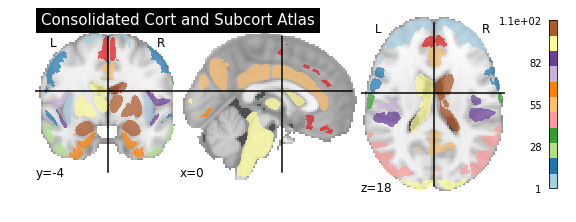

In [27]:
atlas_cort_subcort_img = new_img_like(atlas_cort_img, atlas_cort_subcort_data)
atlas_cort_subcort_img_resampled = resample_to_img(atlas_cort_subcort_img, scans[0], interpolation='nearest')  # not needed here but good practice
print(atlas_cort_subcort_img_resampled.shape)
plotting.plot_roi(atlas_cort_subcort_img, colorbar=True, cmap="Paired", title='Consolidated Cort and Subcort Atlas')

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]
(141, 95, 87)
total labels: 35


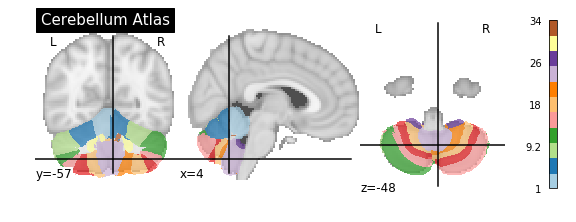

In [28]:
# load the cerebellum atlas and merge with the existing atlas

# load the cerebellum atlas
atlas_cereb_img = load_img('Cerebellum-SUIT-FSLView/Cerebellum-SUIT-maxprob-thr25.nii')
print(np.unique(atlas_cereb_img.get_fdata()))
print(atlas_cereb_img.shape)

#load atlas labels
with open('Cerebellum-SUIT-FSLView/labels.txt', 'r') as f:
    labels_cereb = f.read().split('\n')
print("total labels:", len(labels_cereb))

# visualize
plotting.plot_roi(atlas_cereb_img, colorbar=True, cmap="Paired", title='Cerebellum Atlas')

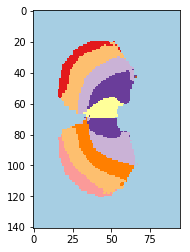

In [29]:
plt.imshow(atlas_cereb_img.get_fdata()[:,:,22], cmap="Paired")

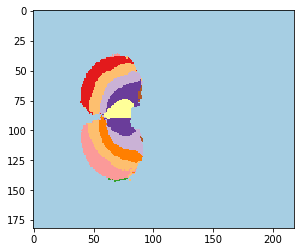

In [30]:
atlas_cereb_img_resampled = resample_to_img(atlas_cereb_img, atlas_cort_subcort_img)
atlas_cereb_img_resampled.shape
atlas_cereb_img_resampled_data = atlas_cereb_img_resampled.get_fdata().astype(int)
plt.imshow(atlas_cereb_img_resampled.get_fdata()[:,:,22], cmap="Paired")

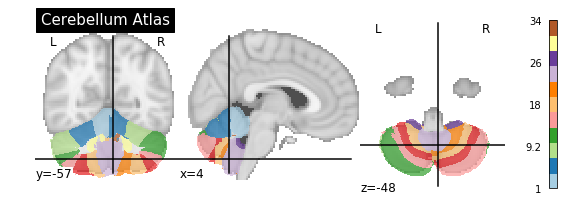

In [31]:
plotting.plot_roi(atlas_cereb_img_resampled, colorbar=True, cmap="Paired", title='Cerebellum Atlas')

In [32]:
# check the overlaps of the cerebellum atlas with the other cort_subcort atlas
overlap = check_overlap(atlas_cereb_img_resampled_data.ravel(), atlas_cort_subcort_data.ravel())
                        #, True, labels_cereb, labels_cort_subcort)

counts_cereb = np.bincount(atlas_cereb_img_resampled_data.ravel())
counts_cort_subcort = np.bincount(atlas_cort_subcort_data.ravel())

od = []
for key in overlap.keys():
    tmp = [labels_cereb[key[0]], labels_cort_subcort[key[1]], overlap[key], \
           counts_cereb[key[0]], overlap[key]/counts_cereb[key[0]]*100, \
           counts_cort_subcort[key[1]], overlap[key]/counts_cort_subcort[key[1]]*100]
    od.append(tmp)
    
pd.DataFrame(od, columns=['cereb region', 'subcort region', 'overlap count', \
                           'cereb total', 'cereb %', 'subcort total', 'subcort %'])

total voxels: 7221032


,cereb region,subcort region,overlap count,cereb total,cereb %,subcort total,subcort %
0,Right Crus I,Right Temporal Occipital Fusiform Cortex,3,21941,0.013673,3152,0.095178
1,Right VI,Right Temporal Occipital Fusiform Cortex,340,13948,2.437625,3152,10.786802
2,Right VI,"Right Temporal Fusiform Cortex, posterior divi...",12,13948,0.086034,2488,0.482315
3,Right V,"Right Temporal Fusiform Cortex, posterior divi...",93,7375,1.261017,2488,3.737942
4,Right V,Right Temporal Occipital Fusiform Cortex,175,7375,2.372881,3152,5.552030
5,Right VI,Right Occipital Fusiform Gyrus,4,13948,0.028678,2314,0.172861
6,Right I-IV,"Right Temporal Fusiform Cortex, posterior divi...",21,8013,0.262074,2488,0.844051
7,Right I-IV,"Right Parahippocampal Gyrus, posterior division",81,8013,1.010857,1251,6.474820
8,Right V,"Right Parahippocampal Gyrus, posterior division",4,7375,0.054237,1251,0.319744
9,Right V,Right Lingual Gyrus,382,7375,5.179661,6060,6.303630


In [33]:
# zero out the overlap
def zero_out_overlap(a, b):
    assert a.shape == b.shape
    shape = a.shape
    a = a.ravel()
    b = b.ravel()
    res = {} # to keep a count of zeroed out voxels
    
    for i in range(len(a)):
        if a[i] != 0 and b[i] != 0:           
            #print(i)
    
            if (a[i], b[i]) not in res.keys():
                res[(a[i], b[i])] = 1
            else:
                res[(a[i], b[i])] += 1  
                
            a[i] = 0
            b[i] = 0
            #break
            
    a = a.reshape(shape)
    b = b.reshape(shape)
    
    return res, a, b

In [34]:
zeroed, atlas_cereb_img_resampled_data, atlas_cort_subcort_data = \
                    zero_out_overlap(atlas_cereb_img_resampled_data, atlas_cort_subcort_data)

In [35]:
# verify no more overlaps
check_overlap(atlas_cereb_img_resampled_data.ravel(), atlas_cort_subcort_data.ravel())

total voxels: 7221032


{}

In [36]:
counts_cereb_new = np.bincount(atlas_cereb_img_resampled_data.ravel())
counts_cort_subcort_new = np.bincount(atlas_cort_subcort_data.ravel())

In [37]:
atlas_cereb_img_resampled_data = \
        list(map(lambda x: adjust_labels(x, len(labels_cort_subcort)-1), atlas_cereb_img_resampled_data.ravel()))
atlas_cereb_img_resampled_data = np.array(atlas_cereb_img_resampled_data).reshape(atlas_data_shape)
np.unique(atlas_cereb_img_resampled_data)

array([  0, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144])

In [38]:
len(labels_cort_subcort)

111

In [39]:
# merge cerebellum atlaas with that of cortical+subcortical
atlas_consolidated_data = atlas_cort_subcort_data + atlas_cereb_img_resampled_data
labels_consolidated = labels_cort_subcort + labels_cereb[1:]

print(atlas_consolidated_data.shape)
print(len(labels_consolidated))
print(len(np.unique(atlas_consolidated_data)))
np.unique(atlas_consolidated_data)

(182, 218, 182)
145
145


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144])

(182, 218, 182)


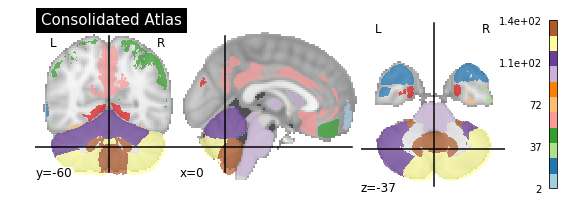

In [40]:
atlas_consolidated_img = new_img_like(atlas_cort_subcort_img, atlas_consolidated_data)
atlas_consolidated_img_resampled = resample_to_img(atlas_consolidated_img, scans[0], interpolation='nearest')  # not needed here but good practice
print(atlas_consolidated_img_resampled.shape)
plotting.plot_roi(atlas_consolidated_img_resampled, colorbar=True, cmap="Paired", title='Consolidated Atlas')

In [3]:
# persist the consolidated atlas and the labels

#atlas_consolidated_img_resampled.to_filename('../data/atlas_consolidated.nii.gz')

#with open("../data/labels.txt", "w") as f:
#    [f.write(str(l) + '\n') for l in labels_consolidated]


# load the consolidated atlas and the labels
atlas_consolidated_img_resampled = load_img('../data/atlas_consolidated.nii.gz')


In [ ]:
masker = NiftiLabelsMasker(labels_img=atlas_consolidated_img_resampled, memory='nilearn_cache', verbose=5)

# doing in batches due to memory constraints
scans_concat = concat_imgs(scans[1000:1402])
transformed = masker.fit_transform(scans_concat)
transformed.shape

In [ ]:
# save results
np.save('../data/1000_1401_relative.npy', transformed)

In [115]:
label_volumes = np.bincount(atlas_consolidated_img_resampled.get_fdata().astype(int).ravel())
print(len(label_volumes))
label_volumes

145


array([6450115,   36594,   42719,    6971,    6938,    8473,    8376,
          8573,    7408,    1411,     966,    2289,    1557,   11081,
          9837,   11752,   11705,     560,     536,    1123,     856,
          4492,    4334,    2360,    3830,     902,     763,    2390,
          1871,    1920,    2889,   10313,    8140,    2297,    3343,
          2894,    2259,    1714,    2559,    1746,    4811,   21675,
         20620,    8393,    7956,    1812,    2003,    2039,    2250,
          2809,    2418,    2647,    2721,    6104,    6124,    5629,
          5961,    5090,    5163,    9813,   10671,    1076,    1154,
          7466,    6571,    2353,    2621,    1119,    1166,    5284,
          5564,     803,     744,    2614,    2362,    1448,    2634,
          2162,    2310,    1113,     708,    4439,    3761,    1917,
          1493,    1054,    1022,     779,     570,    1325,     731,
            13,    9973,    8689,    8549,    9222,    3662,    6167,
          2028,   28

In [56]:
# merge and save results

lesion_load_matrix = np.load('../data/0_499_relative.npy')
lesion_load_matrix = np.concatenate((lesion_load_matrix, np.load('../data/500_999_relative.npy')))
lesion_load_matrix = np.concatenate((lesion_load_matrix, np.load('../data/1000_1400_relative.npy')))
print(lesion_load_matrix.shape)
np.save('../data/lesions_load_matrix_relative.npy', lesion_load_matrix)
lesion_load_matrix = lesion_load_matrix * label_volumes[1:]
lesion_load_matrix = np.round(lesion_load_matrix)
print(lesion_load_matrix.shape)
np.save('../data/lesions_load_matrix_absolute.npy', lesion_load_matrix)

(1401, 144)
(1401, 144)


In [9]:
# load lesion load matrix and labels

lesion_load_matrix = np.load('../data/lesions_load_matrix_absolute.npy')
#lesion_load_matrix = np.load('../data/lesions_load_matrix_relative.npy')

with open('../data/labels.txt', 'r') as f:
    labels_consolidated = [line.rstrip('\n') for line in f]

print(lesion_load_matrix.shape)
print(len(labels_consolidated))

(1401, 144)
145


In [6]:
pd.DataFrame(lesion_load_matrix[lesion_load_matrix>0]).describe()

,0
count,9735.000000
mean,880.526554
std,1857.023168
min,1.000000
25%,30.000000
50%,174.000000
75%,857.500000
max,42678.000000


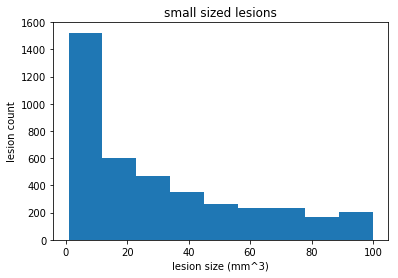

In [6]:
plt.hist(lesion_load_matrix.ravel(), bins=np.linspace(1, 100, 10))
plt.xlabel('lesion size (mm^3)')
plt.ylabel('lesion count')
plt.title("small sized lesions")
plt.show()

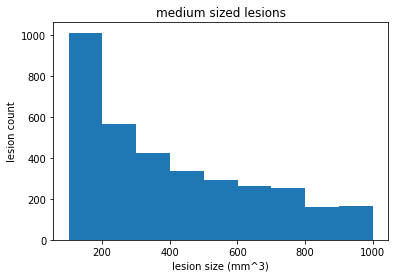

In [7]:
plt.hist(lesion_load_matrix.ravel(), bins=np.linspace(101, 1000, 10))
plt.xlabel('lesion size (mm^3)')
plt.ylabel('lesion count')
plt.title("medium sized lesions")
plt.show()

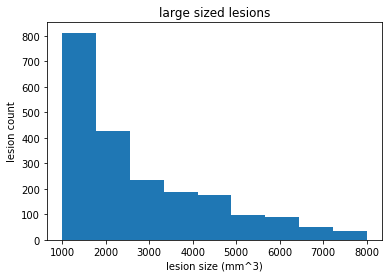

In [10]:
plt.hist(lesion_load_matrix.ravel(), bins=np.linspace(1001, 8000, 10))
plt.xlabel('lesion size (mm^3)')
plt.ylabel('lesion count')
plt.title("large sized lesions")
plt.show()

In [9]:
#Find images that are not mapped to any atlas region

count=0
for i in range(len(lesion_load_matrix)):
    if sum(lesion_load_matrix[i,:])==0:
        #print(i)
        count+=1
print(count)

56


In [5]:
# visualizing some of the scans found above

#plotting.plot_glass_brain(scans[164])
#lesion_load_matrix[164]

In [67]:
# Total_infarct_volume is greater than sum of lesion load matrix. It is because lesion are in the white matter too.
print(sum(lesion_load_matrix[4]))
sample_img = load_img(scans[4])
print(sum(sample_img.get_fdata().ravel()))

2282.0
6488.0


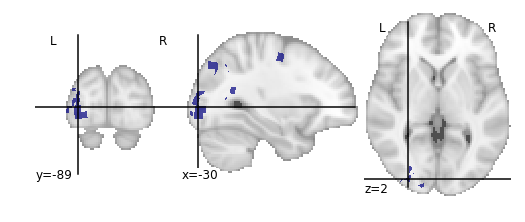

In [323]:
plotting.plot_roi(scans[4])

In [11]:
# take log of lesion loads
lesion_load_df = pd.DataFrame(lesion_load_matrix)
lesion_load_log_df = np.log(1+lesion_load_df)

In [12]:
lesion_load_log_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
count,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,...,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000
mean,0.335140,0.312130,0.619232,0.586476,0.164805,0.178877,0.448559,0.361103,0.193666,0.142144,...,0.195157,0.038260,0.068038,0.042162,0.121926,0.127273,0.036323,0.030911,0.009467,0.008767
std,1.500890,1.452423,1.960414,1.907864,0.941226,0.979307,1.597275,1.461322,1.084727,0.932989,...,1.145069,0.439278,0.518668,0.436520,0.747925,0.783723,0.377464,0.323572,0.134728,0.140095
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.497808,10.661462,8.849657,8.844913,9.026898,9.033245,9.056490,8.910451,7.252762,6.874198,...,8.575651,7.211557,6.184149,6.464588,7.375256,7.352441,5.347108,5.298317,2.302585,2.708050


In [46]:
patient_df = pd.read_excel('/Users/hasnainmamdani/Academics/McGill/thesis/sample-dataset/HallymBundang_database_Bzdok_21082019.xlsx',\
                           sep=',', skipinitialspace=True)
patient_df = patient_df.drop(columns=["ID","Cohort"])
patient_df.head()

,Age,Sex,Education_years,Prior_stroke,IQCODE,MMSE_total_zscore,BostonNamingTest_zscore,ReyComplexFigureTestCopy_zscore,Seoul_Verbal_Learning_Test_immediate_recall_total_zscore,TMT_A_Time_zscore_neg,TMT_B_Time_zscore_neg,Total_infarct_volume
0,66,1,9.0,1,3.25,0.044527,0.296666,0.997443,0.018967,0.097202,-0.019333,0.642
1,66,2,999.0,0,999.00,-2.989856,999.000000,-1.616229,999.000000,999.000000,999.000000,3.098
2,70,2,16.0,0,3.19,0.718835,1.125639,0.775003,0.847892,0.461121,0.254052,1.258
3,68,2,6.0,0,3.21,0.381681,-0.808631,-0.782078,-0.312602,-0.136746,0.154640,3.149
4,74,2,12.0,1,3.00,1.055988,-0.255983,0.385733,-0.312602,-0.162741,-0.006906,6.488


In [47]:
patient_df.describe()

,Age,Sex,Education_years,Prior_stroke,IQCODE,MMSE_total_zscore,BostonNamingTest_zscore,ReyComplexFigureTestCopy_zscore,Seoul_Verbal_Learning_Test_immediate_recall_total_zscore,TMT_A_Time_zscore_neg,TMT_B_Time_zscore_neg,Total_infarct_volume
count,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000
mean,68.378301,2.289079,16.385439,9.403283,254.974532,2.852248,20.678801,79.862955,14.261242,147.603854,231.745182,16.893362
std,27.438600,26.652311,83.504770,95.806058,432.784189,53.331861,142.288225,271.032014,118.552160,354.626520,421.823874,42.968923
min,21.000000,1.000000,0.000000,0.000000,1.250000,-4.001317,-2.742902,-2.895259,-2.467805,-6.739284,-2.628920,0.039000
25%,60.000000,1.000000,6.000000,0.000000,3.080000,-0.461203,-0.532307,-0.448418,-0.644172,-0.032769,0.055227,1.020000
50%,69.000000,2.000000,9.000000,0.000000,3.400000,0.381681,0.296666,0.441343,0.018967,0.383139,0.577144,2.686000
75%,76.000000,2.000000,12.000000,0.000000,999.000000,0.718835,0.849315,0.886223,0.682107,0.643081,0.887809,14.041000
max,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,535.148000


In [48]:
# preprocess variables - fill in the mising values by random sampling of valid values (simple random imputation)
for feature in patient_df.columns:
    invalid_entries = patient_df[patient_df[feature]==999.0].index
    print('feature:', feature, ', \tinvalid values replaced:', len(invalid_entries))
    valid_values = patient_df[feature][patient_df[feature]!=999].values
    patient_df[feature].loc[invalid_entries] = random.choices(list(valid_values), k=len(invalid_entries))
    
patient_df['Sex'] = patient_df['Sex'].map({1: True, 2: False}) # male 0 and female 2
patient_df['Prior_stroke'] = patient_df['Prior_stroke'].map({1.0: True, 0.0: False})

feature: Age , 	invalid values replaced: 1
feature: Sex , 	invalid values replaced: 1
feature: Education_years , 	invalid values replaced: 10
feature: Prior_stroke , 	invalid values replaced: 13
feature: IQCODE , 	invalid values replaced: 354
feature: MMSE_total_zscore , 	invalid values replaced: 4
feature: BostonNamingTest_zscore , 	invalid values replaced: 29
feature: ReyComplexFigureTestCopy_zscore , 	invalid values replaced: 112
feature: Seoul_Verbal_Learning_Test_immediate_recall_total_zscore , 	invalid values replaced: 20
feature: TMT_A_Time_zscore_neg , 	invalid values replaced: 207
feature: TMT_B_Time_zscore_neg , 	invalid values replaced: 325
feature: Total_infarct_volume , 	invalid values replaced: 0


In [49]:
patient_df.head()

,Age,Sex,Education_years,Prior_stroke,IQCODE,MMSE_total_zscore,BostonNamingTest_zscore,ReyComplexFigureTestCopy_zscore,Seoul_Verbal_Learning_Test_immediate_recall_total_zscore,TMT_A_Time_zscore_neg,TMT_B_Time_zscore_neg,Total_infarct_volume
0,66,True,9.0,True,3.25,0.044527,0.296666,0.997443,0.018967,0.097202,-0.019333,0.642
1,66,False,16.0,False,4.15,-2.989856,-1.361280,-1.616229,-1.141526,0.825041,-2.628920,3.098
2,70,False,16.0,False,3.19,0.718835,1.125639,0.775003,0.847892,0.461121,0.254052,1.258
3,68,False,6.0,False,3.21,0.381681,-0.808631,-0.782078,-0.312602,-0.136746,0.154640,3.149
4,74,False,12.0,True,3.00,1.055988,-0.255983,0.385733,-0.312602,-0.162741,-0.006906,6.488


In [53]:
patient_df.describe()

,Age,Education_years,IQCODE,MMSE_total_zscore,BostonNamingTest_zscore,ReyComplexFigureTestCopy_zscore,Seoul_Verbal_Learning_Test_immediate_recall_total_zscore,TMT_A_Time_zscore_neg,TMT_B_Time_zscore_neg,Total_infarct_volume
count,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000
mean,67.725910,9.320842,3.411649,0.000247,0.002788,-0.002704,-0.000203,0.000583,-0.015989,16.893362
std,11.577403,5.203401,0.527425,0.999747,0.999017,1.005466,0.996575,0.995405,1.009347,42.968923
min,21.000000,0.000000,1.250000,-4.001317,-2.742902,-2.895259,-2.467805,-6.739284,-2.628920,0.039000
25%,60.000000,6.000000,3.040000,-0.461203,-0.532307,-0.559638,-0.644172,-0.162741,-0.267865,1.020000
50%,69.000000,9.000000,3.220000,0.381681,0.020342,0.330123,0.018967,0.279162,0.390745,2.686000
75%,76.000000,12.000000,3.570000,0.718835,0.849315,0.775003,0.682107,0.513110,0.651704,14.041000
max,94.000000,23.000000,5.000000,1.055988,1.401964,1.108663,3.500449,0.903023,0.962369,535.148000


In [51]:
# store/load the updated target variables
patient_df.to_hdf('../data/patients.h5', key='p', mode='w')
# patient_df = pd.read_hdf('../data/patients.h5', 'p')